# Assignment 1 | Image Classification, November 12, 2021

- [Artificial Neural Networks and Deep Learning 2021 - Homework 1](https://codalab.lisn.upsaclay.fr/competitions/226)

## Three convolutioneers

- *Aleksandra Krajnovic*
- *Iva Milojkovic*
- *Mariusz Wiśniewski*

### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import shutil
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tfk.layers
print(tf.__version__)

### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 27

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
HISTORIES = []

In [ ]:
def plot_training(histories):
    plt.figure(figsize=(15, 5))
    for idx, history in enumerate(histories):
        plt.plot(history[0]['loss'], label=history[1] + ' training', alpha=.3, color=COLORS[idx], linestyle='--')
        plt.plot(history[0]['val_loss'], label=history[1] + ' validation', alpha=.8, color=COLORS[idx])

    plt.legend(loc='upper right')
    plt.title('Categorical Cross-entropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15, 5))
    for idx, history in enumerate(histories):
        plt.plot(history[0]['categorical_accuracy'], label=history[1] + ' training', alpha=.3, color=COLORS[idx],
                 linestyle='--')
        plt.plot(history[0]['val_categorical_accuracy'], label=history[1] + ' validation', alpha=.8, color=COLORS[idx])

    plt.legend(loc='upper right')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()

In [ ]:
# !unzip dataset.zip -d data

In [ ]:
dataset_dir = 'data'
training_dir = os.path.join(dataset_dir, 'training')

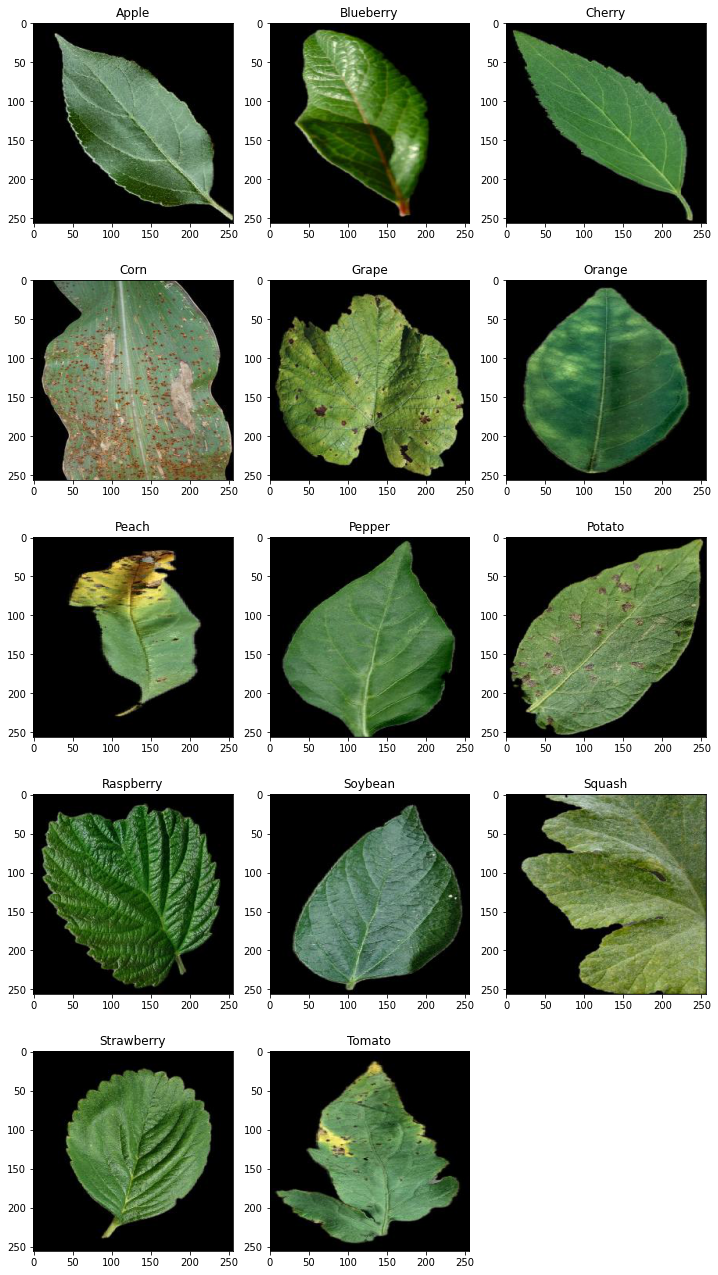

In [ ]:
labels = {0: 'Apple',
          1: 'Blueberry',
          2: 'Cherry',
          3: 'Corn',
          4: 'Grape',
          5: 'Orange',
          6: 'Peach',
          7: 'Pepper',
          8: 'Potato',
          9: 'Raspberry',
          10: 'Soybean',
          11: 'Squash',
          12: 'Strawberry',
          13: 'Tomato'}
# Plot example images from dataset

N_CLASSES = len(labels)

n_rows = 5
n_cols = 3
counts = []

fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_rows, 6 * n_cols))
for i in range(n_rows * n_cols):
    if i < len(labels):
        class_imgs = next(
            os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
        counts.append(len(class_imgs))
        class_img = class_imgs[0]
        img = Image.open(
            '{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i // n_cols, i % n_cols]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
axes[-1, -1].set_visible(False)
plt.tight_layout()
plt.show()

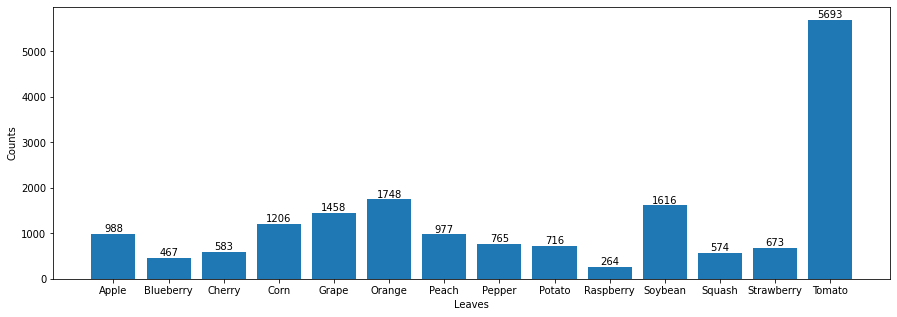

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(labels.values(), counts, align='center')
for i in range(len(counts)):
    plt.annotate(str(counts[i]), xy=(labels[i], counts[i]), ha='center', va='bottom')
plt.xlabel('Leaves')
plt.ylabel('Counts')
plt.show()

### Models metadata

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

### Launch Tensorboard (available under http://localhost:6006)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir experiments

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime


def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, 'cp'),
        save_weights_only=False,
        save_best_only=False)
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)
    callbacks.append(tb_callback)

    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

    return callbacks

## InceptionV3

### Basic augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input

inc_no_aug_train_data_gen = ImageDataGenerator(validation_split=0.2,
                                               preprocessing_function=inception_v3_preprocess_input)

# Create an instance of ImageDataGenerator with Data Augmentation
inc_aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                            height_shift_range=50,
                                            width_shift_range=50,
                                            zoom_range=0.3,
                                            brightness_range=[0.2, 1.0],
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='reflect',
                                            validation_split=0.2,
                                            preprocessing_function=inception_v3_preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
inc_aug_train_gen = inc_aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                               target_size=(
                                                                   256, 256),
                                                               color_mode='rgb',
                                                               classes=None,
                                                               batch_size=8,
                                                               shuffle=True,
                                                               seed=seed,
                                                               subset='training')

inc_valid_gen = inc_no_aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                              target_size=(
                                                                  256, 256),
                                                              color_mode='rgb',
                                                              classes=None,
                                                              batch_size=8,
                                                              shuffle=False,
                                                              seed=seed,
                                                              subset='validation')

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)           

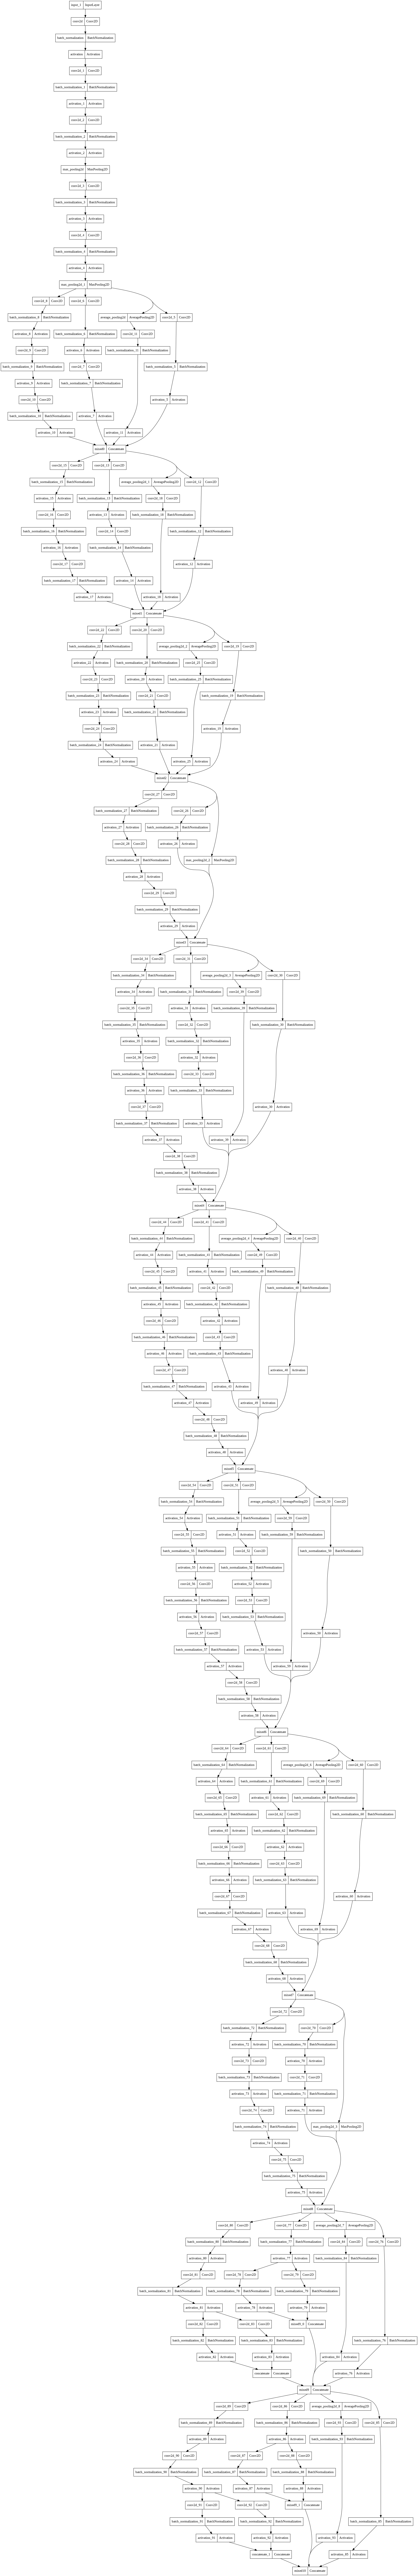

In [ ]:
inception_model = tfk.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
inception_model.summary()
tfk.utils.plot_model(inception_model)

#### Transfer learning

In [ ]:
inception_model.trainable = False

inputs = tfk.Input(shape=input_shape)
out = inception_model(inputs)
out = tfkl.GlobalAveragePooling2D()(out)
out = tfkl.Flatten(name='Flattening')(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
out = tfkl.Dense(
    256,
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
outputs = tfkl.Dense(
    N_CLASSES,
    activation='softmax',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)

# # Connect input and output through the Model class
inc_aug_tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# # Compile the model
inc_aug_tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                         metrics=[
                             tfk.metrics.CategoricalAccuracy(),
                             [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                             [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                         ])
inc_aug_tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 Flattening (Flatten)        (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                             

In [ ]:
inc_aug_tl_callbacks = create_folders_and_callbacks(model_name='CNN_Aug_Inc_TL')

inc_aug_tl_history = inc_aug_tl_model.fit(
    x=inc_aug_train_gen,
    epochs=epochs,
    validation_data=inc_valid_gen,
    callbacks=inc_aug_tl_callbacks,
).history

Epoch 1/200
 112/1774 [>.............................] - ETA: 2:01:07 - loss: 2.2503 - categorical_accuracy: 0.3214 - Precision_Apple: 0.0000e+00 - Precision_Blueberry: 0.0000e+00 - Precision_Cherry: 0.0000e+00 - Precision_Corn: 1.0000 - Precision_Grape: 0.7500 - Precision_Orange: 0.6667 - Precision_Peach: 0.0000e+00 - Precision_Pepper: 0.0000e+00 - Precision_Potato: 0.0000e+00 - Precision_Raspberry: 0.0000e+00 - Precision_Soybean: 0.0000e+00 - Precision_Squash: 0.0000e+00 - Precision_Strawberry: 0.0000e+00 - Precision_Tomato: 0.5804 - Recall_Apple: 0.0000e+00 - Recall_Blueberry: 0.0000e+00 - Recall_Cherry: 0.0000e+00 - Recall_Corn: 0.0333 - Recall_Grape: 0.0316 - Recall_Orange: 0.0241 - Recall_Peach: 0.0000e+00 - Recall_Pepper: 0.0000e+00 - Recall_Potato: 0.0000e+00 - Recall_Raspberry: 0.0000e+00 - Recall_Soybean: 0.0000e+00 - Recall_Squash: 0.0000e+00 - Recall_Strawberry: 0.0000e+00 - Recall_Tomato: 0.2453

KeyboardInterrupt: ignored

In [ ]:
HISTORIES.append((inc_aug_tl_history, 'InceptionV3 TL'))
plot_training(HISTORIES)

In [ ]:
# Save best epoch model
inc_aug_tl_model.save('CNN_Aug_Inc_TL')

#### Fine tuning

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for i, layer in enumerate(inc_aug_tl_model.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

for layer in inc_aug_tl_model.get_layer('inception_v3').layers[:249]:
    layer.trainable = False
for layer in inc_aug_tl_model.get_layer('inception_v3').layers[249:]:
    layer.trainable = True

for i, layer in enumerate(inc_aug_tl_model.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
inc_aug_ft_model = inc_aug_tl_model
inc_aug_ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                         metrics=[
                             tfk.metrics.CategoricalAccuracy(),
                             [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                             [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                         ])
inc_aug_ft_model.summary()

In [ ]:
inc_aug_ft_callbacks = create_folders_and_callbacks(model_name='CNN_Aug_Inc_FT')

inc_aug_ft_history = inc_aug_ft_model.fit(
    x=inc_aug_train_gen,
    epochs=epochs,
    validation_data=inc_valid_gen,
    callbacks=inc_aug_ft_callbacks,
).history

In [ ]:
HISTORIES.append((inc_aug_ft_history, 'InceptionV3 FT'))
plot_training(HISTORIES)

In [ ]:
inc_aug_ft_model.save('CNN_Aug_Inc_FT')
del inc_aug_tl_model
del inc_aug_ft_model

### Augmentation with class weights adjustments

In [ ]:
# Compute class weights (only once because data distribution remains the same for all data generators, same dataset)
class_weights = class_weight.compute_class_weight(
    'balanced',  # balanced for computing weights based on class count
    np.unique(inc_aug_train_gen.classes),
    inc_aug_train_gen.classes)

class_weights = {idx: class_weights[idx] for idx in range(N_CLASSES)}

print(class_weights)

#### Transfer learning

In [ ]:
inception_model.trainable = False

inputs = tfk.Input(shape=input_shape)
out = inception_model(inputs)
out = tfkl.GlobalAveragePooling2D()(out)
out = tfkl.Flatten(name='Flattening')(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
out = tfkl.Dense(
    256,
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
outputs = tfkl.Dense(
    N_CLASSES,
    activation='softmax',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)

# # Connect input and output through the Model class
inc_aug_tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# # Compile the model
inc_aug_tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                         metrics=[
                             tfk.metrics.CategoricalAccuracy(),
                             [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                             [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                         ])
inc_aug_tl_model.summary()

In [ ]:
inc_aug_tl_callbacks_w = create_folders_and_callbacks(model_name='CNN_Aug_Inc_TL_Weights')

inc_aug_tl_history_w = inc_aug_tl_model.fit(
    x=inc_aug_train_gen,
    epochs=epochs,
    validation_data=inc_valid_gen,
    callbacks=inc_aug_tl_callbacks_w,
    class_weight=class_weights
).history

In [ ]:
HISTORIES.append((inc_aug_tl_history_w, 'InceptionV3 TL Weights'))
plot_training(HISTORIES)

In [ ]:
inc_aug_tl_model.save('CNN_Aug_Inc_TL_Weights')

#### Fine tuning

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for i, layer in enumerate(inc_aug_tl_model.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

for layer in inc_aug_tl_model.get_layer('inception_v3').layers[:249]:
    layer.trainable = False
for layer in inc_aug_tl_model.get_layer('inception_v3').layers[249:]:
    layer.trainable = True

for i, layer in enumerate(inc_aug_tl_model.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
inc_aug_ft_model = inc_aug_tl_model

inc_aug_ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                         metrics=[
                             tfk.metrics.CategoricalAccuracy(),
                             [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                             [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                         ])
inc_aug_ft_model.summary()

In [ ]:
inc_aug_ft_callbacks_w = create_folders_and_callbacks(model_name='CNN_Aug_Inc_FT_Weights')

inc_aug_ft_history_w = inc_aug_ft_model.fit(
    x=inc_aug_train_gen,
    epochs=epochs,
    validation_data=inc_valid_gen,
    callbacks=inc_aug_ft_callbacks_w,
    class_weight=class_weights
).history

In [ ]:
HISTORIES.append((inc_aug_ft_history_w, 'InceptionV3 FT Weights'))
plot_training(HISTORIES)

In [ ]:
inc_aug_ft_model.save('CNN_Aug_Inc_FT_Weights')
del inc_aug_tl_model
del inc_aug_ft_model

### Tomato (majority class) reduction

In [ ]:
# 2. Cut off a part of the Tomato data

# The 15% of data remains in the folder, the rest gets moved elsewhere
path = 'data/training/Tomato'
output_folder_name = 'Tomato85'
src_folder = os.path.join(training_dir, 'Tomato')
dest_folder = os.path.join(dataset_dir, output_folder_name)
src_files = os.listdir(src_folder)

os.makedirs(dest_folder, exist_ok=True)

# 15% of files remain, seed is set
for file_to_move in random.sample(src_files, int(len(src_files) * .85)):
    shutil.move(os.path.join(src_folder, file_to_move), dest_folder)

KeyboardInterrupt: ignored

In [ ]:
n_rows = 5
n_cols = 3
counts = []

fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_rows, 6 * n_cols))
for i in range(n_rows * n_cols):
    if i < len(labels):
        class_imgs = next(
            os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
        counts.append(len(class_imgs))
        class_img = class_imgs[0]
        img = Image.open(
            '{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i // n_cols, i % n_cols]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
axes[-1, -1].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(labels.values(), counts, align='center')
for i in range(len(counts)):
    plt.annotate(str(counts[i]), xy=(
        labels[i], counts[i]), ha='center', va='bottom')
plt.xlabel('Leaves')
plt.ylabel('Counts')
plt.show()

#### Transfer learning

In [ ]:
inc_no_aug_train_data_gen = ImageDataGenerator(validation_split=0.2,
                                               preprocessing_function=inception_v3_preprocess_input)

# Create an instance of ImageDataGenerator with Data Augmentation
inc_aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                            height_shift_range=50,
                                            width_shift_range=50,
                                            zoom_range=0.3,
                                            brightness_range=[0.2, 1.0],
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='reflect',
                                            validation_split=0.2,
                                            preprocessing_function=inception_v3_preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
inc_aug_train_gen = inc_aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                               target_size=(
                                                                   256, 256),
                                                               color_mode='rgb',
                                                               classes=None,
                                                               batch_size=8,
                                                               shuffle=True,
                                                               seed=seed,
                                                               subset='training')

inc_valid_gen = inc_no_aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                              target_size=(
                                                                  256, 256),
                                                              color_mode='rgb',
                                                              classes=None,
                                                              batch_size=8,
                                                              shuffle=False,
                                                              seed=seed,
                                                              subset='validation')

In [ ]:
inception_model.trainable = False

inputs = tfk.Input(shape=input_shape)
out = inception_model(inputs)
out = tfkl.GlobalAveragePooling2D()(out)
out = tfkl.Flatten(name='Flattening')(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
out = tfkl.Dense(
    256,
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
outputs = tfkl.Dense(
    N_CLASSES,
    activation='softmax',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)

# # Connect input and output through the Model class
inc_aug_tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# # Compile the model
inc_aug_tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                         metrics=[
                             tfk.metrics.CategoricalAccuracy(),
                             [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                             [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                         ])
inc_aug_tl_model.summary()

In [ ]:
inc_aug_tl_callbacks_r = create_folders_and_callbacks(model_name='CNN_Aug_Inc_TL_Reduced')

inc_aug_tl_history_r = inc_aug_tl_model.fit(
    x=inc_aug_train_gen,
    epochs=epochs,
    validation_data=inc_valid_gen,
    callbacks=inc_aug_tl_callbacks_r
).history

In [ ]:
HISTORIES.append((inc_aug_tl_history_r, 'InceptionV3 TL Reduced'))
plot_training(HISTORIES)

In [ ]:
inc_aug_tl_model.save('CNN_Aug_Inc_TL_Reduced')

#### Fine tuning

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for i, layer in enumerate(inc_aug_tl_model.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

for layer in inc_aug_tl_model.get_layer('inception_v3').layers[:249]:
    layer.trainable = False
for layer in inc_aug_tl_model.get_layer('inception_v3').layers[249:]:
    layer.trainable = True

for i, layer in enumerate(inc_aug_tl_model.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
inc_aug_ft_model = inc_aug_tl_model

inc_aug_ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                         metrics=[
                             tfk.metrics.CategoricalAccuracy(),
                             [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                             [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                              range(N_CLASSES)],
                         ])
inc_aug_ft_model.summary()

In [ ]:
inc_aug_ft_callbacks_r = create_folders_and_callbacks(model_name='CNN_Aug_Inc_FT_Reduced')

inc_aug_ft_history_r = inc_aug_ft_model.fit(
    x=inc_aug_train_gen,
    epochs=epochs,
    validation_data=inc_valid_gen,
    callbacks=inc_aug_ft_callbacks_r
).history

In [ ]:
HISTORIES.append((inc_aug_ft_history_r, 'InceptionV3 FT Reduced'))
plot_training(HISTORIES)

In [ ]:
inc_aug_ft_model.save('CNN_Aug_Inc_FT_Reduced')
del inc_aug_tl_model
del inc_aug_ft_model

#### Merge back the Tomato85/ folder

In [ ]:
# The 15% of data remains in the folder, the rest gets moved elsewhere
path = 'data/training/Tomato'
output_folder_name = 'Tomato85'
dest_folder = os.path.join(training_dir, 'Tomato')
src_folder = os.path.join(dataset_dir, output_folder_name)
src_files = os.listdir(src_folder)

os.makedirs(dest_folder, exist_ok=True)

# 15% of files remain, seed is set
for file_to_move in random.sample(src_files, int(len(src_files))):
    shutil.move(os.path.join(src_folder, file_to_move), dest_folder)

os.rmdir(src_folder)

FileNotFoundError: ignored